## Grid World

### Importing required libs

In [390]:
from enum import Enum
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
import copy
import random

# The Grid
To create a grid, I decided to build a helper class to define cells, their types, and the grid containing the cells. Also, methods were developed to facilitate the visualization of the agent and the paths.

For better visualization, green represents terrain, brown for mountains, and orange for quicksand.

One of the most interesting points, was finding out in the middle of the implementation that a path-finding algorithm was necessary. This was the case due to the random disposition of mountains and quicksand over the grid. Sometimes, during testing, after adding the terrain types, reaching the goal was impossible. Adding a simple (not so efficient) path-finding algorithm check,solved the issue. Although not implemented, A* here could be a faster alternative.

In [391]:
cmap = colors.ListedColormap(['Green','#8B4513', 'Orange'])

class CellType(Enum):
  """Enum for different types of cells in the grid.

  Attributes:
      TERRAIN (float): Represents normal terrain with a value of 0.0.
      MOUNTAIN (float): Represents mountainous terrain with a value of 1.0.
      QUICKSAND (float): Represents quicksand with a value of 2.0.
  """
  TERRAIN = 0.0
  MOUNTAIN = 1.0
  QUICKSAND = 2.0

class GridCell:
  """Represents a single cell in the grid.

  Attributes
      gridType (CellType): The type of cell (terrain, mountain, quicksand).
      position (tuple): The (x, y) position of the cell in the grid.
      state (int): The numerical state representation of the cell.
  """
  def __init__(self, gridType : CellType, position, state):
    """Initializes a GridCell object with a type, position, and state."""
    self.position = position
    self.gridType = gridType
    self.state = state

In [392]:
class Grid:
  """Represents the grid environment where an agent can move.

      Attributes:
        grid (list): A 2D list of GridCell objects representing the environment.
        agent_position (tuple): The current (x, y) position of the agent in the grid.
        q_table (np.ndarray): A table used for Q-learning, initialized based on the grid size.
  """

  def __init__(self, height, width):
    self.grid = self.make_grid(height, width)
    self.agent_position = (0,0)
    self.q_table = self.make_q()

  def view_grid_path(self, path):
    """Visualizes a path taken through the grid.

    Args:
        path (list): A list of (x, y) tuples representing the path taken.
    """
    grid_float = np.zeros((len(self.grid), len(self.grid[0])), dtype=float)
    for i in range(len(self.grid)):
      for j in range(len(self.grid[i])):
        grid_float[i][j] = self.grid[i][j].gridType.value
    plt.figure(figsize=(6, 6))
    plt.pcolor(grid_float[::-1], cmap=cmap, edgecolors='k', linewidths=3)


    plot_path = [(p[0] + 0.5, len(self.grid) - p[1] - 0.5) for p in path]
    x, y = zip(*plot_path)


    plt.plot(x, y, color='white', linewidth=2, marker='o', markersize=5, markerfacecolor='black')

    plt.show()

  def insert_random_mountains(self, probability):
      """Randomly inserts mountain cells into the grid based on a given probability.

      Args:
          probability (float): The probability of converting a terrain cell into a mountain cell.
      """
      grid_copy = None
      feasible = False
      goal_position = (len(self.grid[0]) - 1, len(self.grid) - 1)

      while not feasible:
          grid_copy = copy.deepcopy(self.grid)
          for i in range(len(grid_copy)):
              for j in range(len(grid_copy[i])):
                  if (j, i) != self.agent_position and (j, i) != goal_position:
                      if random.random() < probability:
                          grid_copy[i][j].gridType = CellType.MOUNTAIN
          feasible = self.is_reachable(grid_copy)
      self.grid = grid_copy

  def insert_random_quicksand(self, probability):
      """Randomly inserts quicksand cells into the grid based on a given probability.

        Args:
            probability (float): The probability of converting a terrain cell into a quicksand cell.
      """
      grid_copy = None
      feasible = False
      goal_position = (len(self.grid[0]) - 1, len(self.grid) - 1)

      while not feasible:
          grid_copy = copy.deepcopy(self.grid)
          for i in range(len(grid_copy)):
              for j in range(len(grid_copy[i])):
                  if (j, i) != self.agent_position and (j, i) != goal_position:
                      if random.random() < probability:
                          grid_copy[i][j].gridType = CellType.QUICKSAND
          feasible = self.is_reachable(grid_copy)
      self.grid = grid_copy

  def sample(self):
    """Creates a deep copy of the current grid.

    Returns:
        A deep copy of the grid, allowing for simulations or modifications without affecting the original grid.
    """
    return copy.deepcopy(self)

  def is_reachable(self, grid):
    """Determines if the goal position is reachable from the agent's position, avoiding mountains and quicksand.

    Args:
        grid (list): A 2D list of GridCell objects representing a grid configuration.

    Returns:
        bool: True if the goal position is reachable from the agent's position, False otherwise.
    """
    queue = [self.agent_position]
    visited = np.zeros((len(grid), len(grid[0])), dtype=bool)
    while queue:
      current_pos = queue.pop(0)
      if current_pos == (len(grid[0]) - 1, len(grid) - 1):
        return True

      if visited[current_pos[1]][current_pos[0]]:
        continue

      visited[current_pos[1]][current_pos[0]] = True

      movements = [(0,1),(0, -1), (1,0), (-1,0)]

      for move in movements:
        new_pos = (current_pos[0] + move[0], current_pos[1] + move[1])

        if 0 <= new_pos[0] < len(grid[0]) and 0 <= new_pos[1] <len(grid):
          if grid[new_pos[1]][new_pos[0]].gridType != CellType.QUICKSAND and grid[new_pos[1]][new_pos[0]].gridType != CellType.MOUNTAIN:
            if not visited[new_pos[1]][new_pos[0]]:
              queue.append(new_pos)
    return False

  def make_grid(self, height, width):
    """Creates a grid of the specified dimensions with all cells initially set as terrain.

    Args:
        height (int): The height of the grid.
        width (int): The width of the grid.

    Returns:
        A list of lists containing GridCell objects, representing the grid.
    """
    grid = []
    state = 0
    for i in range(height):
      grid_cells = []
      for j in range(width):
        grid_cells.append(GridCell(CellType.TERRAIN, (j,i), state))
        state += 1
      grid.append(grid_cells)
    return grid

  def make_q(self):
    """Initializes the Q-table for Q-learning, based on the grid size and number of possible actions.

    Returns:
        A numpy array representing the initialized Q-table with dimensions [number of states, number of actions].
    """
    q_table = np.zeros((len(self.grid) * len(self.grid[0]), 4), dtype=float)
    return q_table

  def view_grid(self, grid):
    """Visualizes the grid with different colors representing different cell types.

    Args:
        grid (list): A 2D list of GridCell objects to visualize.
    """
    grid_float = np.zeros((len(grid), len(grid[0])), dtype=float)
    for i in range(len(grid)):
      for j in range(len(grid[i])):
        grid_float[i][j] = grid[i][j].gridType.value
    plt.figure(figsize=(6,6))
    plt.pcolor(grid_float[::-1],cmap=cmap,edgecolors='k', linewidths=3)

    first_square_center = (0.5, len(grid) - 0.5)
    last_square_center = (len(grid[0]) - 0.5, 0.5)

    plt.plot(first_square_center[0], first_square_center[1], 'o', color='black', markersize=10)
    plt.plot(last_square_center[0], last_square_center[1], 'o', color='blue', markersize=10)
    plt.show()

## Q Learning
The initial approach I took was to implement Q-Learning. Even though it doesn't quite fit into the category of iterative methods through dynamic programming, I chose to develop it as a means for benchmarking and result comparison.

To put it simply, Q-Learning is a type of Model-Free reinforcement learning algorithm. It focuses on learning the value of taking certain actions within specific states. In this implementation, I've utilized the e-greedy exploration method. This means that initially, the agent explores various actions to discover new possibilities, but as the learning process progresses, it gradually starts to prioritize actions that yield better outcomes, adhering to a more greedy approach.

In [393]:
class QLearning:
  """
  Implements the Q-Learning algorithm for a grid environment.

  Attributes:
      grid_obj (Grid): The grid environment object.
      grid (list): The grid structure, extracted from grid_obj.
      epsilon (float): The initial epsilon for the epsilon-greedy policy.
      minimum_epsilon (float): The minimum value epsilon can decay to.
      epsilon_decay (float): The decay rate of epsilon after each episode.
      alpha (float): The learning rate.
      gamma (float): The discount factor for future rewards.
      agent_position (tuple): The current position of the agent (x, y).
      agent_start_position (tuple): The starting position of the agent (x, y).
      goal_position (tuple): The goal position in the grid (x, y).
      q_table (np.ndarray): The Q-table for storing state-action values.

  Methods:
      epsilon_greedy_action(state): Returns an action based on the epsilon-greedy policy.
      update_q_table(state, action, reward, next_state): Updates the Q-table based on agent's experience.
      take_action(action): Moves the agent based on the given action and updates its position.
      render(path_taken): Visualizes the path taken by the agent in the grid.
      run_episode(): Runs a single episode of the Q-Learning algorithm.
      run_multiple_episodes(count): Runs multiple episodes and prints the learning progress.
  """
  def __init__(self, grid_obj, initial_epsilon, minimum_epsilon, alpha, gamma, agent_start_position, goal_position):
    """
      Initializes the QLearning object with the grid environment and learning parameters.
    """
    self.grid_obj = grid_obj
    self.grid = self.grid_obj.grid
    self.epsilon = initial_epsilon
    self.minimum_epsilon = minimum_epsilon
    self.epsilon_decay = 0.01
    self.alpha = alpha
    self.gamma = gamma
    self.agent_position = agent_start_position
    self.agent_start_position = agent_start_position
    self.goal_position = goal_position
    self.q_table = np.zeros((len(self.grid) * len(self.grid[0]), 4), dtype=float)

  def epsilon_greedy_action(self, state):
    """
    Selects an action using the epsilon-greedy policy.

    Args:
        state (int): The current state index.

    Returns:
        int: The selected action index.
    """
    if np.random.rand() < self.epsilon:
      return np.random.randint(4)
    else:
      return np.argmax(self.q_table[state])

  def update_q_table(self, state, action, reward, next_state):
    """
    Updates the Q-table using the Q-learning update rule.

    Args:
        state (int): The current state index.
        action (int): The action taken.
        reward (float): The reward received after taking the action.
        next_state (int): The next state index.
    """
    max_future_q = np.max(self.q_table[next_state])
    current_q = self.q_table[state, action]
    new_q = current_q + self.alpha * (reward + self.gamma * max_future_q - current_q)
    self.q_table[state, action] = new_q

  def take_action(self, action):
    """
    Executes the given action and updates the agent's position in the grid.

    Args:
        action (int): The action to take.

    Returns:
        tuple: A tuple containing the action taken, the new state index, the reward, and a done flag.
    """
    original_position = self.agent_position
    reward = 0
    done = False
    next_position = list(self.agent_position)

    if action == 0 and self.agent_position[0] < len(self.grid[0]) - 1:
        next_position[0] += 1
    elif action == 1 and self.agent_position[0] > 0:
        next_position[0] -= 1
    elif action == 2 and self.agent_position[1] < len(self.grid) - 1:
        next_position[1] += 1
    elif action == 3 and self.agent_position[1] > 0:
        next_position[1] -= 1


    if self.grid[next_position[1]][next_position[0]].gridType in [CellType.MOUNTAIN, CellType.QUICKSAND]:
        reward = -50 if self.grid[next_position[1]][next_position[0]].gridType == CellType.MOUNTAIN else -100
        done = True if self.grid[next_position[1]][next_position[0]].gridType == CellType.QUICKSAND else False
    else:
        self.agent_position = tuple(next_position)
        reward += -1

    if self.agent_position == (len(self.grid[0]) - 1, len(self.grid) - 1):
        reward = 0
        done = True

    if self.agent_position == original_position:
      reward += -1

    state = self.grid[self.agent_position[1]][self.agent_position[0]].state
    return action, state, reward, done

  def render(self, path_taken):
    """
    Visualizes the path taken by the agent on the grid.

    Args:
        path_taken (list): A list of positions (tuples) representing the agent's path.
    """
    self.grid_obj.view_grid_path(path_taken)

  def run_episode(self):
    """
    Runs a single episode of the Q-Learning algorithm.

    Returns:
        tuple: A tuple containing the path taken and the total score (reward) for the episode.
    """
    self.agent_position = self.agent_start_position
    path = [self.agent_position]
    state = self.grid[self.agent_position[1]][self.agent_position[0]].state
    done = False
    score = 0
    while not done:
      action = self.epsilon_greedy_action(state)
      _, next_state, reward, done = self.take_action(action)
      self.update_q_table(state, action, reward, next_state)
      state = next_state
      path.append(self.agent_position)
      if self.epsilon > self.minimum_epsilon:
        self.epsilon -= self.epsilon_decay
      score += reward
    return path, score

  def run_multiple_episodes(self, count):
    """
    Runs multiple episodes of the Q-Learning algorithm and prints the progress.

    Args:
        count (int): The number of episodes to run.
    """
    scores = []
    for episode in range(count):
      path_taken, score = self.run_episode()
      if episode % 100 == 0:
        print(f"Episode {episode} | Score {score}")
      scores.append(score)
    path_taken, final_score = self.run_episode()
    scores.append(final_score)
    print(f"Reward for potted grid: {final_score}")
    self.render(path_taken)

## Iterative Policy
Following the Q-Learning, I shifted to this Dynamic programming approach to Reinforcement Learning. Iterative Policy requires a perfect model of the environment, that follows the Markov Decision Process. It converges to the optimal policy that maximizes rewards over the long run. It operates in two defined phases:
- Policy Evaluation
- Policy Improvement

In Policy Evaluation, the value of following a given policy is assessed. Complementary to this process, Policy Improvement actually updates the current policy based on the first step. This process is looped util it stabilizes, which means that the policy stops being updated.

In [394]:
class IterativePolicy:
  """
  Implements an iterative policy improvement algorithm for a grid environment.

  This class is designed to find an optimal policy for navigating a grid environment with obstacles and a goal
  using the policy iteration method which includes policy evaluation and policy improvement phases.

  Attributes:
      grid_obj (Grid): An instance of the Grid class representing the grid environment.
      grid (list): A list of lists representing the grid environment, extracted from grid_obj.
      discount_factor (float): The discount factor, gamma, used in the update equation.
      agent_position (tuple): The current position of the agent in the grid as (x, y) coordinates.
      agent_start_position (tuple): The starting position of the agent in the grid as (x, y) coordinates.
      goal_position (tuple): The goal position in the grid as (x, y) coordinates that the agent aims to reach.
      v_table (np.ndarray): The value table for storing the value of each state.
      p_table (np.ndarray): The policy table for storing the policy's action probabilities for each state.

  Methods:
      take_action(action): Simulates the agent taking a specified action in the environment and updates the agent's position.
      render(path_taken): Visualizes the agent's path through the grid.
      take_action_from_state(state, action): Determines the next state and reward given a current state and action.
      state_to_position(state): Converts a state index to its corresponding position in the grid.
      bellman_update(policy, old_v_table, state, gamma): Performs the Bellman update for a single state.
      policy_evaluation(p_table, gamma, theta): Evaluates a policy by updating the value table until convergence.
      update_policy(state, best_actions): Updates the policy for a given state based on the best actions determined.
      policy_improvement(gamma): Improves the current policy based on the value table.
      policy_iteration(): Performs policy iteration, alternating between policy evaluation and improvement until convergence.
      simulate_policy(): Simulates and visualizes the agent following the current policy from the start to the goal position.
  """
  def __init__(self, grid_obj, discount_factor, agent_start_position, goal_position):
    """
    Initializes an IterativePolicy object with the given grid environment, discount factor, start position, and goal position.
    """
    self.grid_obj = grid_obj
    self.grid = self.grid_obj.grid
    self.discount_factor = discount_factor
    self.agent_position = agent_start_position
    self.agent_start_position = agent_start_position
    self.goal_position = goal_position
    self.v_table = np.zeros((len(self.grid) * len(self.grid[0]),), dtype=float)
    self.p_table = np.full((len(self.grid) * len(self.grid[0]), 4), 0.25, dtype=float)

  def take_action(self, action):
    """
    Executes the given action and updates the agent's position in the grid.

    Args:
        action (int): The action to be taken by the agent.

    Returns:
        tuple: A tuple containing the action taken, the new state index, the reward received, and a boolean indicating if the goal is reached or if the episode ended.
    """
    original_position = self.agent_position
    reward = 0
    done = False
    next_position = list(self.agent_position)

    if action == 0 and self.agent_position[0] < len(self.grid[0]) - 1:
        next_position[0] += 1
    elif action == 1 and self.agent_position[0] > 0:
        next_position[0] -= 1
    elif action == 2 and self.agent_position[1] < len(self.grid) - 1:
        next_position[1] += 1
    elif action == 3 and self.agent_position[1] > 0:
        next_position[1] -= 1


    if self.grid[next_position[1]][next_position[0]].gridType in [CellType.MOUNTAIN, CellType.QUICKSAND]:
        reward = -50 if self.grid[next_position[1]][next_position[0]].gridType == CellType.MOUNTAIN else -100
        done = True if self.grid[next_position[1]][next_position[0]].gridType == CellType.QUICKSAND else False
    else:
        self.agent_position = tuple(next_position)
        reward += -1

    if self.agent_position == (len(self.grid[0]) - 1, len(self.grid) - 1):
        reward = 0
        done = True

    if self.agent_position == original_position:
      reward += -1

    state = self.grid[self.agent_position[1]][self.agent_position[0]].state
    return action, state, reward, done

  def take_action_from_state(self, state, action):
    """
    Determines the outcome of taking an action from a given state.

    Args:
        state (int): The current state index from which the action is taken.
        action (int): The action to be taken.

    Returns:
        tuple: A tuple containing the action taken, the next state index, the reward received, and a boolean indicating if the goal is reached.
    """
    self.agent_position = self.state_to_position(state)
    return self.take_action(action)

  def state_to_position(self, state):
    """
    Converts a state index to its corresponding (x, y) position in the grid.

    Args:
        state (int): The state index to be converted.

    Returns:
        tuple: The (x, y) position corresponding to the given state index.
    """
    rows = len(self.grid)
    cols = len(self.grid[0])
    return (state % cols, state // cols)

  def bellman_update(self, policy, old_v_table, state, gamma):
    """
    Performs the Bellman update for a given state.

    This method updates the value function for a specific state based on the Bellman equation, using the current policy.

    Args:
        policy (np.ndarray): The current policy under evaluation.
        old_v_table (np.ndarray): The value table before the current update iteration.
        state (int): The index of the state to update.
        gamma (float): The discount factor used in the calculation.

    Note:
        If the state corresponds to the goal position, no update is performed.
    """
    state_pos = self.state_to_position(state)
    if state_pos[0] == self.goal_position[0] and state_pos[1] == self.goal_position[1]:
      return None

    value = 0
    for i in range(0, 4):
      action, next_state, reward, done = self.take_action_from_state(state, i)
      value += policy[state, i] * (reward + gamma * old_v_table[next_state])
    self.v_table[state] = value

  def policy_evaluation(self, p_table, gamma, theta):
    """
    Performs the policy evaluation step in policy iteration.

    It iteratively updates the value function until the change is less than a small threshold for all states.

    Args:
        p_table (np.ndarray): The current policy being evaluated.
        gamma (float): The discount factor for future rewards.
        theta (float): The small threshold determining the accuracy of the evaluation.

    Note:
        This method updates `self.v_table` in-place and prints the delta every 10 iterations.
    """
    count = 0
    while True:
      old_v_table = self.v_table.copy()
      delta = 0
      for state in range(0, len(self.v_table)):
        self.bellman_update(p_table, old_v_table, state, gamma)

        delta = max(delta, abs(old_v_table[state] - self.v_table[state]))
      if count % 10 == 0:
        print(delta) if delta > 0 else None
      if delta < theta:
        break
      count +=1

  def update_policy(self, state, best_actions):
    """
    Updates the policy for a specific state based on the best actions identified.

    Args:
        state (int): The index of the state for which to update the policy.
        best_actions (list): A list of action indices considered best for this state.

    Note:
        The policy is updated to assign equal probability to all best actions.
    """
    prob = 1 / len(best_actions)

    for i in range(0,4):
      self.p_table[state, i] = prob if i in best_actions else 0

  def policy_improvement(self, gamma):
    """
    Performs the policy improvement step in policy iteration.

    It iterates over all states, updating the policy based on the action that maximizes the expected utility.

    Args:
        gamma (float): The discount factor for future rewards.

    Returns:
        bool: True if the policy is stable (no change), False otherwise.

    Note:
        This method updates `self.p_table` in-place and checks for policy stability.
    """
    policy_stable = True
    for state in range(0, len(self.v_table)):
      old_prob = self.p_table[state, ].copy()

      best_actions = []
      max_v = None

      for i in range(0, 4):
        action, next_state, reward, done = self.take_action_from_state(state, i)
        current_expected = reward + gamma * self.v_table[next_state]

        if max_v is None:
          max_v = current_expected
          best_actions.append(i)
        elif current_expected > max_v:
          max_v = current_expected
          best_actions = [i]
        elif current_expected == max_v:
          best_actions.append(i)

      self.update_policy(state, best_actions)

      if not np.array_equal(old_prob, self.p_table[state, ]):
          policy_stable = False
    return policy_stable

  def policy_iteration(self):
    """
    Executes the policy iteration algorithm.

    This method repeatedly evaluates and improves the policy until it becomes stable.

    Note:
        After policy stabilization, `simulate_policy` is called to visualize the optimal path.
    """
    count = 0
    policy_stable = False
    while not policy_stable:
      self.policy_evaluation(self.p_table, self.discount_factor, 0.01)
      policy_stable = self.policy_improvement(self.discount_factor)
      count +=1
    self.simulate_policy()

  def simulate_policy(self):
    """
    Simulates agent movement through the grid following the current policy.

    It starts from the agent's start position and moves according to the policy until reaching the goal or exceeding a maximum step count.

    Note:
        The path and total score are printed, and the path is visualized using `view_grid_path`.
    """
    self.agent_position = self.agent_start_position
    path = [self.agent_start_position]
    current_position = self.agent_start_position
    steps = 0
    current_state = self.grid[self.agent_position[1]][self.agent_position[0]].state
    max_steps = len(self.grid) * len(self.grid[0]) * 2
    score = 0
    while current_position != self.goal_position and steps < max_steps:
        action_probabilities = self.p_table[current_state]
        action = np.argmax(action_probabilities)

        _, next_state, reward, _ = self.take_action(action)
        next_position = self.state_to_position(next_state)

        if next_position != current_position or next_position == self.goal_position:
            path.append(next_position)

        current_position = next_position
        current_state = next_state
        score += reward
        steps += 1
    print(f"Reward for plotted grid: {score}")
    self.grid_obj.view_grid_path(path)


# Experiments
For experimenting with the two approaches, a random grid sample was taken, from a 32x32 grid. Since the sample replicates the original grid state, it is expected for both grids to have the same terrain distribution, including quicksand and mountains.

In [412]:
base_grid = Grid(32,32)
base_grid.insert_random_mountains(0.3)
base_grid.insert_random_quicksand(0.1)

q_copy_grid = base_grid.sample()
ip_copy_grid = base_grid.sample()
example_copy_grid = base_grid.sample()
example2_copy_grid = base_grid.sample()

### Q-Learning Test

Episode 0 | Score -940
Episode 100 | Score -163
Episode 200 | Score -281
Reward for potted grid: -346


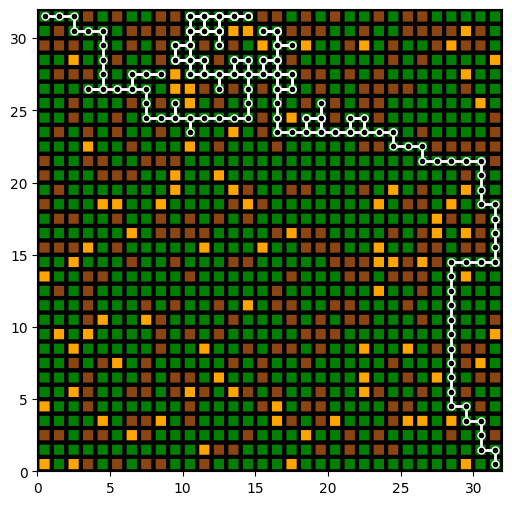

CPU times: user 834 ms, sys: 116 ms, total: 950 ms
Wall time: 835 ms


In [413]:
%%time
goal_position = (len(q_copy_grid.grid[0]) - 1, len(q_copy_grid.grid) - 1)
q_learning_imp = QLearning(q_copy_grid, 1, 0.01, 1, 0.9, (0,0), goal_position)
q_learning_imp.run_multiple_episodes(300)

### Iterative Policy Test

76.0
26.499561447599945
9.239825748883277
3.221728028916459
1.1233471035490084
0.39168691575628145
0.13657278279345064
0.047619984864581966
0.016604062040187273
237.1092790870896
15.723410779045452
5.482414343489097
1.9115996812696459
0.6665335949607609
0.23240589416516322
0.08103492464755568
0.02825513111972988
0.00985195504364711
14.596508667479775
0.5971019465236811
0.2081965752945507
0.07259365710786625
0.025311843121526678
2.531111779937902
0.6740311792493188
4.782988310775709
0.02632060331032271
1.5541655235452412
0.14714420854558874
0.0513060131054246
0.010117099432248366
1.4900148147273766
0.09434970520022112
0.009549206137480226
1.172617508981241
0.009258539112485309
1.2157665488356297
1.09418989260765
0.011359289213963564
0.7237902532124618
0.7559188515894331
0.6715140108259732
0.5945704368494678
0.5242332010601789
0.4597207786160027
0.05996387069326836
0.020908108895687505
0.40031636482311406
0.3453599106393721
0.29424078879606874
0.24639100905049816
0.20127890718326746
0.15

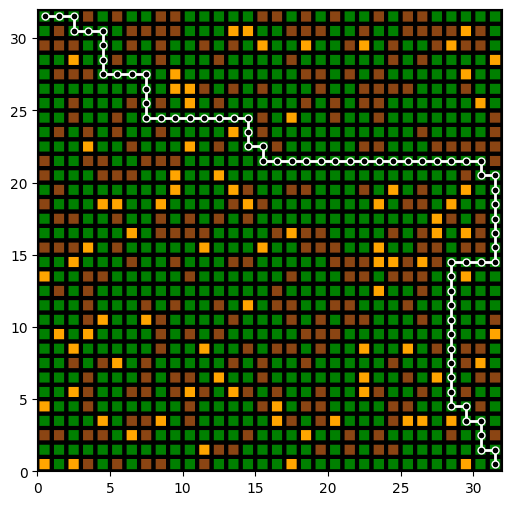

CPU times: user 7.93 s, sys: 162 ms, total: 8.09 s
Wall time: 8.09 s


In [414]:
%%time
goal_position = (len(ip_copy_grid.grid[0]) - 1, len(ip_copy_grid.grid) - 1)
ip_learning = IterativePolicy(ip_copy_grid, 0.9, (0,0), goal_position)
ip_learning.policy_iteration()

## Reults
While not exploratory, the first results showed a few interesting aspects. First, both algorithms reached the same goal. The Q-Learning took way less time to find a path, but resulted in worse scores. While IP struggled a little bit more with time, it actually found an optimal path, with just -63 of score.

About the route choice, it's interesting to see that it focused on going even near quicksand blocks, which could have impacted the value of those states.

## Another Test
Back to the Q-Learning algorithm, I decided to increase the number of episodes, to see if it would converge.

#### 600 Episodes (300 + than before)
After increasing the number of episodes to 600, the Q-Learning algorithm found thesame solution as the iterative policy algorithm. It shows that tunning hyperparameters between the algos can change theirs results drastically.

Episode 0 | Score -1231
Episode 100 | Score -186
Episode 200 | Score -283
Episode 300 | Score -183
Episode 400 | Score -121
Episode 500 | Score -79
Reward for potted grid: -67


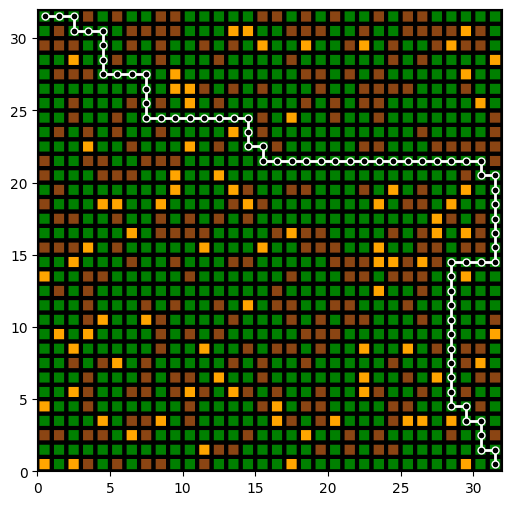

CPU times: user 1.43 s, sys: 218 ms, total: 1.65 s
Wall time: 1.46 s


In [415]:
%%time
goal_position = (len(example_copy_grid.grid[0]) - 1, len(example_copy_grid.grid) - 1)
q_learning_imp = QLearning(example_copy_grid, 1, 0.01, 1, 0.9, (0,0), goal_position)
q_learning_imp.run_multiple_episodes(600)

For instance, trying to run the Iterative Policy with a gamma value of 1, reduced its performance, and sometives even got suck in an eternal loop.

In [417]:
%%time
goal_position = (len(example2_copy_grid.grid[0]) - 1, len(example2_copy_grid.grid) - 1)
ip_learning = IterativePolicy(example2_copy_grid, 1, (0,0), goal_position)
ip_learning.policy_iteration()

76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0
76.0


KeyboardInterrupt: 